<a href="https://colab.research.google.com/github/rainardw/TUBES_PEMPAR/blob/main/TUGAS_BESAR_PEMPAR_KELOMPOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**KELOMPOK 7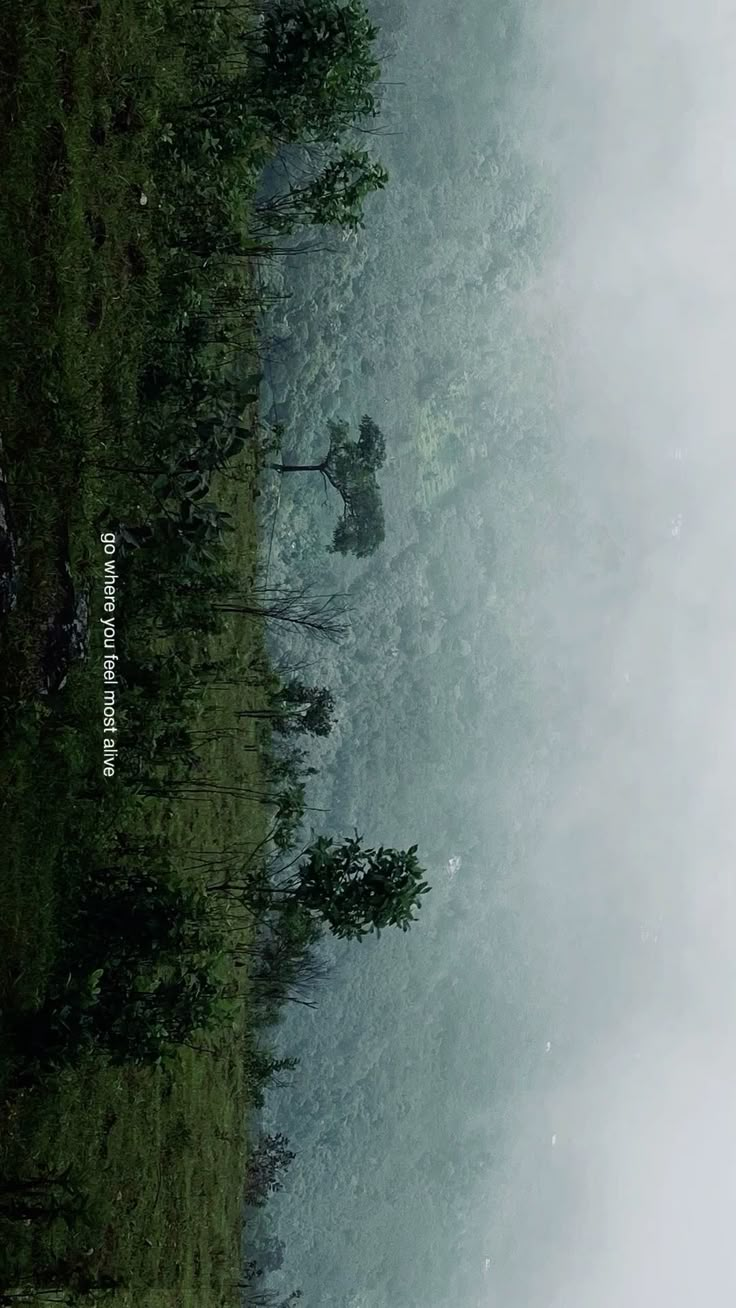**

>**TUGAS BESAR PEMROGRAMAN PARALEL: DETEKSI POLA PENYAKIT JANTUNG, KANKER, DAN LIVER MELALUI PEMROSESAN PARALEL DENGAN SPARK CONTEXT, SPARK SQL, DAN MPI**

---

## **ANGGOTA KELOMPOK**

In [1]:
group_members = {
    "ADITYA": "F1D02310",
    "DATU REKSA HAMZA PUTRA": "F1D02310",
    "KURNIA DWI SURYA": "F1D02310013"
}

# Link Dataset Kaggle
kaggle_link = "https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver"

print("ANGGOTA KELOMPOK 7:")
for name, nim in group_members.items():
    print(f"{name} - {nim}")

print("\nLink Dataset:", kaggle_link)


ANGGOTA KELOMPOK 7:
ADITYA - F1D02310
DATU REKSA HAMZA PUTRA - F1D02310
KURNIA DWI SURYA - F1D02310013

Link Dataset: https://www.kaggle.com/datasets/yug201/disease-cancer-heart-liver


## **LIBRARY YANG DIGUNAKAN**

In [52]:
from pyspark.sql.functions import lit
from pyspark.sql.types import StringType, IntegerType
from pyspark import SparkContext
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from pyspark.sql.functions import col, when, count
from pyspark.sql.functions import avg, round
from mpi4py import MPI

Dalam program ini, digunakan sejumlah library penting yang mendukung pemrosesan data berskala besar secara paralel. Library pyspark.sql.functions digunakan untuk berbagai fungsi manipulasi kolom seperti lit, col, when, dan count, yang sangat berguna dalam membentuk, mengubah, dan menganalisis data pada DataFrame Spark. Selain itu, StringType dan IntegerType dari pyspark.sql.types digunakan untuk mendefinisikan tipe data eksplisit saat menambahkan kolom baru, memastikan konsistensi tipe data di seluruh DataFrame.

SparkContext dan SparkSession merupakan komponen utama dari Apache Spark yang memungkinkan pembentukan konteks pemrosesan data terdistribusi. SparkSession berfungsi sebagai titik masuk utama untuk bekerja dengan struktur DataFrame, sedangkan SparkContext memberikan akses lebih rendah ke inti engine Spark dan digunakan dalam beberapa operasi transformasi RDD.

Untuk kebutuhan analisis visual dan manipulasi data secara lokal, digunakan juga pandas dan numpy untuk konversi hasil akhir ke DataFrame dan pemrosesan numerik, serta matplotlib.pyplot untuk menghasilkan grafik visualisasi seperti diagram batang dan garis. Di sisi lain, multiprocessing (mp) dimanfaatkan untuk membagi data menjadi beberapa bagian (chunks) dan memprosesnya secara paralel di berbagai core CPU, guna mempercepat proses komputasi lokal.

Terakhir, mpi4py.MPI diimpor sebagai bagian dari implementasi Message Passing Interface (MPI) dalam Python. MPI memberikan kemampuan untuk melakukan pemrosesan paralel terdistribusi antar-node, berbeda dengan multiprocessing yang bekerja pada multi-core dalam satu mesin. Kombinasi MPI, PySpark, dan Spark SQL memungkinkan analisis data berskala besar secara efisien, sekaligus memperlihatkan bagaimana sistem paralel dapat meningkatkan performa pemrosesan data penyakit jantung, kanker, dan liver secara signifikan.

## **INSTALASI PySpark**

In [3]:
!pip install pyspark
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("DiseaseAnalysis").getOrCreate()

### **Alur Kerja Program**

Program ini bertujuan melakukan analisis data penyakit menggunakan **PySpark**. Berikut adalah alur kerjanya:

1. **Instalasi PySpark**
   Program diawali dengan perintah `!pip install pyspark` yang digunakan untuk menginstal pustaka PySpark agar bisa digunakan dalam lingkungan Python seperti Google Colab atau Jupyter Notebook.

2. **Inisialisasi SparkContext**
   `sc = SparkContext.getOrCreate()` digunakan untuk membuat atau mendapatkan objek `SparkContext`. Objek ini adalah inti dari Spark yang mengatur komunikasi dengan cluster dan pengelolaan resource selama eksekusi program.

3. **Inisialisasi SparkSession**
   `spark = SparkSession.builder.appName("DiseaseAnalysis").getOrCreate()` membuat sebuah sesi Spark bernama "DiseaseAnalysis". `SparkSession` memungkinkan pemrosesan data menggunakan DataFrame, SQL, serta fitur Spark lainnya dalam satu interface terpadu.

4. **Tujuan Program**
   Pemberian nama aplikasi "DiseaseAnalysis" menunjukkan bahwa program ini kemungkinan besar akan digunakan untuk menganalisis data yang berkaitan dengan penyakit, baik itu untuk pembersihan data, eksplorasi, maupun pengambilan insight dari dataset besar secara paralel dan efisien.


## **ANALISIS DATA PENYAKIT MENGGUNAKAN PySpark RDD**

In [8]:
rdd_heart = sc.textFile("/content/heart.csv")
rdd_cancer = sc.textFile("/content/cancer patient data sets.csv")
rdd_liver = sc.textFile("/content/indian_liver_patient (1).csv")

header = rdd_heart.first()

data_heart = rdd_heart.filter(lambda row: row != header)
data_cancer = rdd_cancer.filter(lambda row: row != header)
data_liver = rdd_liver.filter(lambda row: row != header)

# Gabungkan semua data
data_all = data_heart.union(data_cancer).union(data_liver)

# Filter penyakit 'Heart Disease'
filtered_heart = data_all.filter(lambda row: "Heart Disease" in row)

# Tampilkan hasil
print("Contoh baris dengan Heart Disease:")
print(filtered_heart.take(5))

# Hitung jumlah kasus
heart_count = filtered_heart.count()
print(f"Jumlah kasus Heart Disease: {heart_count}")


Contoh baris dengan Heart Disease:
[]
Jumlah kasus Heart Disease: 0


## **Fungsi Program**

Memuat data dari tiga file CSV yang berisi informasi pasien dengan penyakit jantung, kanker, dan liver. Menghapus baris header agar tidak ikut dihitung sebagai data. Menggabungkan ketiga dataset menjadi satu RDD besar. Melakukan filter terhadap baris yang mengandung kata "Heart Disease". Menampilkan contoh baris hasil filter. Menghitung jumlah kasus yang terkait dengan penyakit jantung.

###  **Alur Kerja Program**

1. **Membaca File CSV sebagai RDD**
   Program memuat tiga dataset CSV menggunakan `sc.textFile()` dan menyimpannya ke dalam `rdd_heart`, `rdd_cancer`, dan `rdd_liver`.

2. **Mengambil dan Menghapus Header**
   Baris pertama dari dataset jantung (`rdd_heart.first()`) diambil sebagai `header`. Selanjutnya, setiap dataset difilter untuk membuang baris header tersebut agar tidak memengaruhi hasil analisis.

3. **Menggabungkan Seluruh Data**
   Data yang telah dibersihkan dari ketiga RDD kemudian digabungkan menjadi satu RDD besar `data_all` menggunakan operasi `union()`.

4. **Melakukan Filter Berdasarkan Kata Kunci**
   RDD hasil gabungan difilter kembali untuk mencari baris yang mengandung kata **"Heart Disease"**, dan hasilnya disimpan dalam `filtered_heart`.

5. **Menampilkan dan Menghitung**
   Program menampilkan 5 baris pertama dari hasil filter dan menghitung jumlah total kasus penyakit jantung menggunakan `.count()`.


# **ANALISIS DATASET PENYAKIT DENGAN PySpark DATAFRAME**

In [6]:
# Buat SparkSession
spark = SparkSession.builder.appName("AnalisisPenyakit").getOrCreate()

# Baca CSV
df_heart = spark.read.csv("/content/heart.csv", header=True, inferSchema=True)
df_heart.show(5)
df_heart.printSchema()

df_cancer = spark.read.csv("/content/cancer patient data sets.csv", header=True, inferSchema=True)
df_cancer.show(5)
df_cancer.printSchema()

df_liver = spark.read.csv("/content/indian_liver_patient (1).csv", header=True, inferSchema=True)
df_liver.show(5)
df_liver.printSchema()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

# **Fungsi utama**

dari program ini adalah membaca tiga file CSV yang berisi data pasien dengan penyakit jantung, kanker, dan liver ke dalam format DataFrame menggunakan `PySpark.` Setiap DataFrame dihasilkan melalui metode `spark.read.csv()` dengan opsi `header=True `untuk mengenali baris pertama sebagai nama kolom, dan `inferSchema=True `agar Spark secara otomatis mendeteksi tipe data tiap kolom. Setelah data dibaca, ditampilkan lima baris pertama dari masing-masing DataFrame dengan `.show(5`) untuk memberi gambaran awal terhadap isi `dataset. `Kemudian, struktur kolom beserta tipe datanya dicetak menggunakan `.printSchema`() untuk membantu pengguna memahami jenis data yang tersedia dan mempersiapkan proses analisis lanjutan seperti pembersihan data, eksplorasi, atau visualisasi.

### **Alur Kerja Program**

1. **Inisialisasi SparkSession**
   Program memulai dengan membuat objek `SparkSession` bernama "AnalisisPenyakit", yang menjadi pintu utama untuk bekerja dengan DataFrame dan SQL di PySpark.

2. **Membaca Dataset Penyakit Jantung**
   File `heart.csv` dibaca sebagai DataFrame `df_heart`, lalu ditampilkan lima baris pertamanya dan struktur kolomnya.

3. **Membaca Dataset Penyakit Kanker**
   File `cancer patient data sets.csv` dibaca sebagai DataFrame `df_cancer`, lalu ditampilkan isi awal dan skema kolomnya.

4. **Membaca Dataset Penyakit Liver**
   File `indian_liver_patient (1).csv` dibaca sebagai DataFrame `df_liver`, dengan proses penampilan data dan skema yang sama.

# **PEMERIKSAAN DATA NULL PADA DATASET PENYAKIT**

In [10]:
def cek_null(df, nama_dataset):
    print(f"\nJumlah null pada dataset {nama_dataset}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

cek_null(df_heart, "Heart")
cek_null(df_cancer, "Cancer")
cek_null(df_liver, "Liver")


Jumlah null pada dataset Heart:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+


Jumlah null pada dataset Cancer:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|index|Pat

### **Fungsi Program**

Fungsi `cek_null()` dirancang untuk menghitung jumlah nilai **null** di setiap kolom dalam suatu DataFrame. Fungsi ini menerima dua parameter: `df` (DataFrame yang akan diperiksa) dan `nama_dataset` (nama dataset untuk ditampilkan sebagai label). Di dalam fungsi, digunakan kombinasi fungsi `when()` dan `isNull()` dari PySpark untuk mengecek apakah sebuah kolom memiliki nilai kosong. Seluruh kolom dicek sekaligus menggunakan list comprehension, dan hasilnya ditampilkan dalam bentuk tabel menggunakan `.show()`. Fungsi ini dipanggil untuk tiga dataset berbeda, yaitu `df_heart`, `df_cancer`, dan `df_liver`, sehingga pengguna dapat melihat kolom mana saja yang memiliki nilai hilang dan memutuskan langkah penanganan selanjutnya.

### **Alur Kerja Program**

1. **Mendefinisikan Fungsi cek\_null**
   Fungsi `cek_null()` dibuat untuk menghitung dan menampilkan jumlah nilai null di setiap kolom DataFrame yang diberikan.

2. **Pemeriksaan Dataset Penyakit Jantung**
   Fungsi dipanggil dengan parameter `df_heart` dan nama "Heart", lalu mencetak jumlah nilai null per kolom.

3. **Pemeriksaan Dataset Penyakit Kanker**
   Fungsi dipanggil kembali untuk `df_cancer` dengan label "Cancer".

4. **Pemeriksaan Dataset Penyakit Liver**
   Fungsi terakhir dijalankan untuk `df_liver` dengan nama "Liver".

### **ANALISIS DISTRIBUSI KATEGORY PENYAKIT DENGAN PySpark**

In [11]:
df_heart.groupBy("HeartDisease").count().show()
df_liver.groupBy("Dataset").count().show()
df_cancer.groupBy("Level").count().show()

+------------+-----+
|HeartDisease|count|
+------------+-----+
|           1|  508|
|           0|  410|
+------------+-----+

+-------+-----+
|Dataset|count|
+-------+-----+
|      1|  416|
|      2|  167|
+-------+-----+

+------+-----+
| Level|count|
+------+-----+
|  High|  365|
|   Low|  303|
|Medium|  332|
+------+-----+



### **Fungsi Program**

Program ini menggunakan fungsi `groupBy()` dan `count()` dari PySpark DataFrame untuk menghitung jumlah baris (data pasien) pada tiap kategori penyakit dalam kolom target dari masing-masing dataset. Pada dataset penyakit jantung, pengelompokan dilakukan berdasarkan kolom `HeartDisease` untuk mengetahui berapa banyak pasien yang menderita atau tidak menderita penyakit tersebut. Pada dataset liver, kolom `Dataset` digunakan sebagai penanda label target antara pasien sehat dan penderita. Sedangkan pada dataset kanker, kolom `Level` mencerminkan tingkat keparahan penyakit atau klasifikasi status pasien. Hasil dari setiap operasi ditampilkan menggunakan `.show()` untuk melihat jumlah data pada tiap kategori secara langsung.

### **Alur Kerja Program**

1. **Mengelompokkan dan Menghitung Data pada Dataset Jantung**
   Dataset `df_heart` dikelompokkan berdasarkan kolom `HeartDisease`, kemudian dihitung jumlah data pada tiap kelompok.

2. **Mengelompokkan dan Menghitung Data pada Dataset Liver**
   Dataset `df_liver` dikelompokkan berdasarkan kolom `Dataset`, lalu ditampilkan hasil jumlah data per kategori.

3. **Mengelompokkan dan Menghitung Data pada Dataset Kanker**
   Dataset `df_cancer` dikelompokkan berdasarkan kolom `Level` untuk melihat distribusi jumlah data pada masing-masing tingkat.

### **STATISTIK DATASET PENYAKIT JANTUNG**

In [15]:
df_heart = df_heart.toDF(*[c.strip().replace(" ", "_") for c in df_heart.columns])
print("\nStatistik Heart Dataset:")
df_heart.select(
    round(avg("Age"), 2).alias("Rata-rata_Usia"),
    round(avg("Cholesterol"), 2).alias("Rata-rata_Kolesterol"),
    round(avg("MaxHR"), 2).alias("Rata-rata_Detak_Jantung_Maks")
).show()



Statistik Heart Dataset:
+--------------+--------------------+----------------------------+
|Rata-rata_Usia|Rata-rata_Kolesterol|Rata-rata_Detak_Jantung_Maks|
+--------------+--------------------+----------------------------+
|         53.51|               198.8|                      136.81|
+--------------+--------------------+----------------------------+



### **Fungsi Program**

Fungsi program ini adalah untuk menghitung **rata-rata usia**, **kolesterol**, dan **detak jantung maksimal (MaxHR)** dari data pasien pada dataset penyakit jantung. Sebelum dilakukan perhitungan, nama-nama kolom terlebih dahulu dibersihkan dengan menghapus spasi dan menggantinya dengan garis bawah (`_`) agar sesuai dengan standar pemanggilan kolom di PySpark. Pembersihan dilakukan menggunakan `toDF()` dan list comprehension. Setelah itu, digunakan fungsi agregasi `avg()` yang dibungkus dengan `round()` untuk membulatkan hasil ke dua angka desimal. Kolom hasil ditampilkan dengan nama alias yang menjelaskan makna data, seperti `Rata-rata_Usia`. Seluruh hasil ditampilkan dengan `show()`.

### **Alur Kerja Program**

1. **Membersihkan Nama Kolom**
   Semua nama kolom pada `df_heart` diubah agar tidak mengandung spasi, sehingga memudahkan pemanggilan dalam operasi analisis.

2. **Menghitung Rata-Rata Atribut**
   Dilakukan perhitungan rata-rata pada tiga kolom utama: `Age`, `Cholesterol`, dan `MaxHR`, yang masing-masing diberi nama alias untuk menjelaskan maknanya.

3. **Menampilkan Statistik**
   Hasil rata-rata dari ketiga kolom tersebut ditampilkan dalam format tabel untuk memberi gambaran umum mengenai profil pasien dalam dataset.

### **FILTER PASIEN BERDASARKAN KOLESTEROL DAN USIA**

In [18]:
print("\nPasien dengan kolesterol > 240 dan usia > 50:")
df_heart.filter((col("Cholesterol") > 240) & (col("Age") > 50)).show(5)


Pasien dengan kolesterol > 240 dan usia > 50:
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 54|  F|          ATA|      120|        273|        0|    Normal|  150|             N|    1.5|    Flat|           0|
| 60|  M|          ASY|      100|        248|        0|    Normal|  125|             N|    1.0|    Flat|           1|
| 53|  M|          ASY|      124|        260|        0|        ST|  112|             Y|    3.0|    Flat|           0|
| 52|  M|          ATA|      120|        284|        0|    Normal|  118|             N|    0.0|      Up|           0|
| 53|  F|          ATA|      113|        468|        0|    Normal|  127|             N|    0.0|      Up|           0|
+---+---+

### **Fungsi Program**

Fungsi dari baris kode ini adalah menyaring (filter) data pasien yang memiliki kadar **kolesterol lebih dari 240** dan **usia lebih dari 50 tahun**. Penyaringan dilakukan dengan metode `filter()` menggunakan operator logika `&` untuk menggabungkan dua kondisi. Kondisi pertama memeriksa apakah nilai pada kolom `Cholesterol` melebihi 240, dan kondisi kedua memeriksa apakah nilai `Age` melebihi 50. Pasien yang memenuhi kedua syarat ini dianggap memiliki risiko tinggi terhadap penyakit jantung. Hasil penyaringan ditampilkan menggunakan `show(5)` untuk melihat lima baris data pertama yang sesuai dengan kriteria.

### **Alur Kerja Program**

1. **Menerapkan Filter Data**
   Dataset `df_heart` difilter berdasarkan dua syarat: kolesterol > 240 dan usia > 50.

2. **Menampilkan Hasil Filter**
   Lima baris pertama dari data pasien yang memenuhi kedua kriteria tersebut ditampilkan agar bisa dianalisis lebih lanjut.

### **ANALISIS PASIEN BERDASARKAN PENYAKIT JANTUNG**

In [31]:
rdd_heart = df_heart.rdd

gender_count_heart = rdd_heart.map(lambda row: (row["Sex"], 1)).reduceByKey(lambda a, b: a + b)
df_gender_heart = gender_count_heart.toDF(["Sex", "Count"])
df_gender_heart.show()

+---+-----+
|Sex|Count|
+---+-----+
|  M|  725|
|  F|  193|
+---+-----+



### **Fungsi Program**

Fungsi program ini adalah untuk menghitung jumlah pasien berdasarkan kolom `Sex` dalam dataset penyakit jantung. Pertama, DataFrame `df_heart` diubah menjadi bentuk RDD agar dapat diproses menggunakan transformasi RDD. Kemudian, dilakukan pemetaan (`map`) terhadap setiap baris data untuk menghasilkan pasangan `(Sex, 1)`, di mana `Sex` adalah jenis kelamin pasien dan `1` sebagai nilai hitungannya. Proses ini dilanjutkan dengan `reduceByKey()` untuk menjumlahkan seluruh nilai berdasarkan jenis kelamin. Hasil akhir kemudian dikonversi kembali menjadi DataFrame menggunakan `toDF()` agar bisa ditampilkan dengan metode `show()`. Dengan demikian, pengguna bisa melihat seberapa banyak pasien pria dan wanita yang tercatat dalam dataset.

###  **Alur Kerja Program**

1. **Konversi DataFrame ke RDD**
   DataFrame `df_heart` diubah menjadi RDD untuk bisa menggunakan transformasi berbasis RDD.

2. **Pemetaan Jenis Kelamin**
   Setiap baris data dipetakan menjadi pasangan `(Sex, 1)` untuk tujuan penghitungan.

3. **Pengelompokan dan Penjumlahan**
   Pasangan tersebut dikumpulkan dan dijumlahkan berdasarkan kunci `Sex` menggunakan `reduceByKey`.

4. **Konversi Kembali ke DataFrame**
   Hasil RDD berupa jumlah pasien berdasarkan jenis kelamin dikonversi kembali menjadi DataFrame.

5. **Menampilkan Hasil**
   Data ditampilkan untuk memberikan gambaran proporsi pasien pria dan wanita dalam dataset penyakit jantung.

### **ANALISIS PASIEN BERDASARKAN PENYAKIT LIVER (HATI)**

In [33]:
rdd_liver = df_liver.rdd

gender_count_liver = rdd_liver.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
df_gender_liver = gender_count_liver.toDF(["Gender", "Count"])
df_gender_liver.show()

+------+-----+
|Gender|Count|
+------+-----+
|Female|  142|
|  Male|  441|
+------+-----+



### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien berdasarkan jenis kelamin (`Gender`) dalam dataset penyakit liver. Langkah pertama adalah mengubah `DataFrame` `df_liver` menjadi `RDD` agar dapat diproses dengan transformasi RDD. Kemudian, setiap baris data dipetakan ke dalam pasangan `(Gender, 1)` yang berarti setiap kemunculan jenis kelamin diberi nilai 1. Setelah itu, dilakukan proses `reduceByKey` untuk menjumlahkan total pasien per jenis kelamin. Hasilnya dikonversi kembali ke bentuk DataFrame dengan nama kolom `Gender` dan `Count`, lalu ditampilkan dengan `show()` untuk melihat distribusinya. Ini sangat berguna dalam analisis awal untuk melihat apakah distribusi gender dalam data cenderung seimbang atau tidak.

### **Alur Kerja Program**

1. **Mengubah DataFrame ke RDD**
   Dataset `df_liver` diubah ke dalam bentuk `RDD` untuk memungkinkan penggunaan operasi `map` dan `reduceByKey`.

2. **Pemetaan Data Pasien Berdasarkan Gender**
   Setiap baris dipetakan menjadi pasangan `(Gender, 1)` sebagai dasar perhitungan.

3. **Menjumlahkan Total Tiap Jenis Kelamin**
   Digunakan `reduceByKey` untuk mengakumulasi jumlah kemunculan setiap jenis kelamin.

4. **Konversi Kembali ke DataFrame**
   Hasil akhir RDD dikonversi menjadi DataFrame untuk kemudahan visualisasi.

5. **Menampilkan Hasil Analisis**
   Jumlah pasien laki-laki dan perempuan ditampilkan untuk mengetahui distribusinya dalam dataset liver.

### **ANALISIS PASIEN BERDASARKAN PENYAKIT KANKER**

In [27]:
rdd = df_cancer.rdd

gender_count = rdd.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
df_gender = gender_count.toDF(["Gender", "Count"])
df_gender.show()

+------+-----+
|Gender|Count|
+------+-----+
|     1|  598|
|     2|  402|
+------+-----+



### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien laki-laki dan perempuan pada dataset kanker. Pertama, DataFrame `df_cancer` diubah menjadi RDD untuk memungkinkan manipulasi data dengan cara fungsional. Kemudian, setiap baris dalam RDD dipetakan menjadi pasangan `(Gender, 1)`, yang berarti setiap kemunculan jenis kelamin dihitung sebagai satu. Setelah itu, `reduceByKey` digunakan untuk menggabungkan nilai berdasarkan kunci `Gender` sehingga menghasilkan jumlah total pasien untuk masing-masing jenis kelamin. Hasil RDD ini dikonversi kembali ke bentuk DataFrame agar bisa ditampilkan secara lebih rapi dan mudah dipahami.

### **Alur Kerja Program**

1. **Konversi DataFrame ke RDD**
   Dataset `df_cancer` diubah ke bentuk RDD agar bisa menggunakan transformasi `map` dan `reduceByKey`.

2. **Pemetaan Data Berdasarkan Gender**
   Setiap baris dimapping menjadi `(Gender, 1)` sebagai pasangan kunci dan nilai.

3. **Pengelompokan dan Penjumlahan**
   Gunakan `reduceByKey` untuk menjumlahkan jumlah pasien berdasarkan jenis kelamin.

4. **Konversi ke DataFrame**
   Hasil perhitungan dikonversi ke DataFrame untuk kemudahan visualisasi.

5. **Menampilkan Hasil**
   Tampilkan jumlah pasien laki-laki dan perempuan dari dataset kanker menggunakan `show()`.

### **ANALISIS JUMLAH PASIEN BERDASARKAN JENIS KELAMIN DENGAN SQL PADA DATASET PENYAKIT JANTUNG**

In [25]:
df_heart.createOrReplaceTempView("data_penyakit")

spark.sql("SELECT Sex, COUNT(*) as Jumlah FROM data_penyakit GROUP BY Sex").show()

+---+------+
|Sex|Jumlah|
+---+------+
|  F|   193|
|  M|   725|
+---+------+



### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien berdasarkan jenis kelamin dengan pendekatan SQL menggunakan Spark. Langkah pertama adalah membuat *temporary view* dari `DataFrame` `df_heart` agar bisa diakses menggunakan perintah SQL. Dengan `createOrReplaceTempView`, dataset dinamai `data_penyakit`. Kemudian, query SQL dijalankan untuk memilih kolom `Sex` dan menghitung jumlah baris (pasien) yang termasuk dalam tiap kategori jenis kelamin dengan `GROUP BY`. Hasil query ditampilkan menggunakan `show()` sehingga pengguna dapat melihat distribusi jumlah pasien pria dan wanita secara langsung menggunakan sintaks SQL.

### **Alur Kerja Program**

1. **Membuat View Sementara dari DataFrame**
   Dataset `df_heart` diubah menjadi *temporary view* bernama `data_penyakit`.

2. **Menjalankan Query SQL**
   SQL query dijalankan untuk memilih kolom `Sex` dan menghitung jumlah pasien per jenis kelamin menggunakan `COUNT(*)`.

3. **Mengelompokkan Berdasarkan Jenis Kelamin**
   Gunakan `GROUP BY` untuk mengelompokkan pasien berdasarkan nilai pada kolom `Sex`.

4. **Menampilkan Hasil**
   Hasil query ditampilkan untuk memberikan informasi jumlah pasien laki-laki dan perempuan dalam dataset penyakit jantung.

### **STATISTIK RATA-RATA USIA DAN RISIKO GENETIK PADA DATASET KANKER**

In [34]:
print("\nStatistik Cancer Dataset:")
df_cancer.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Genetic Risk"), 2).alias("Rata-rata Risiko Genetik")
).show()


Statistik Cancer Dataset:
+--------------+------------------------+
|Rata-rata Usia|Rata-rata Risiko Genetik|
+--------------+------------------------+
|         37.17|                    4.58|
+--------------+------------------------+



### **Fungsi Program**

Fungsi dari program ini adalah untuk menampilkan statistik deskriptif berupa rata-rata usia dan rata-rata risiko genetik dari pasien dalam dataset kanker. Program ini memanfaatkan method `select()` dan fungsi `avg()` untuk mengambil nilai rata-rata dari kolom `Age` dan `Genetic Risk`. Hasil rata-rata tersebut kemudian dibulatkan hingga dua angka desimal menggunakan fungsi `round()` agar lebih rapi dan mudah dibaca. Output akhir ditampilkan menggunakan `show()` sehingga pengguna bisa langsung melihat informasi statistik dasar dari dua fitur penting tersebut.

### **Alur Kerja Program**

1. **Memilih Kolom yang Akan Dianalisis**
   Kolom `Age` dan `Genetic Risk` dipilih karena relevan untuk analisis statistik dasar.

2. **Menghitung Nilai Rata-rata**
   Gunakan fungsi `avg()` untuk menghitung nilai rata-rata pada kedua kolom.

3. **Pembulatan Hasil**
   Fungsi `round()` digunakan untuk membulatkan hasil rata-rata menjadi dua angka di belakang koma.

4. **Menampilkan Statistik**
   Hasil akhir berupa rata-rata usia dan rata-rata risiko genetik ditampilkan dalam bentuk tabel menggunakan `show()`.

## **FILTERING PASIEN KANKER DENGAN RISIKO GENETIK POSITIF DAN USIA DI ATAS 50 TAHUN**

In [35]:
print("\nFiltering pasien dengan risiko genetik > 0 dan usia > 50:")
df_cancer.filter((col("Genetic Risk") > 0) & (col("Age") > 50)).show(5)


Filtering pasien dengan risiko genetik > 0 dan usia > 50:
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring| Level|
+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+-------



### **Fungsi Program**

Fungsi dari program ini adalah untuk menyaring dan menampilkan data pasien yang memenuhi dua kriteria penting: memiliki nilai `Genetic Risk` lebih besar dari 0, dan berusia lebih dari 50 tahun. Penyaringan dilakukan menggunakan method `filter()` dengan kondisi logika `&` (dan) untuk memastikan kedua syarat terpenuhi secara bersamaan. Kolom `Genetic Risk` dan `Age` dibandingkan menggunakan `col()` dari Spark, dan hasil yang lolos filter ditampilkan sebanyak lima baris pertama dengan `show(5)`. Analisis seperti ini berguna untuk fokus pada pasien yang berisiko lebih tinggi.

### **Alur Kerja Program**

1. **Menentukan Kondisi Penyaringan**
   Kondisi difokuskan pada pasien dengan risiko genetik > 0 dan usia > 50.

2. **Menerapkan Filter ke DataFrame**
   Method `filter()` digunakan untuk menyaring data sesuai dua kondisi tersebut.

3. **Menampilkan Hasil Filter**
   Hasil filter ditampilkan dengan `show(5)` untuk melihat 5 contoh pasien yang memenuhi kriteria.

## **ANALISIS JUMLAH PASIEN KANKER BERDASARKAN JENIS KELAMIN MENGGUNAKAN RDD DAN REDUCEBYKEY**

In [36]:
print("\nRDD ReduceByKey - Gender Count (Cancer):")
rdd_cancer = df_cancer.rdd
gender_cancer = rdd_cancer.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_cancer.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Cancer):
1: 598
2: 402




### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung total pasien laki-laki dan perempuan dari dataset kanker dengan memanfaatkan transformasi RDD. Pertama, DataFrame `df_cancer` dikonversi menjadi bentuk RDD agar bisa diproses secara fungsional. Setiap elemen dalam RDD dipetakan ke pasangan `(Gender, 1)` yang menyatakan satu kemunculan jenis kelamin tertentu. Kemudian, `reduceByKey` digunakan untuk menjumlahkan nilai-nilai berdasarkan gender, sehingga menghasilkan total pasien untuk masing-masing jenis kelamin. Hasil akhir dikumpulkan ke driver menggunakan `collect()` dan ditampilkan satu per satu dengan perulangan `for`.

### **Alur Kerja Program**

1. **Konversi DataFrame ke RDD**
   Dataset kanker (`df_cancer`) diubah menjadi RDD untuk manipulasi berbasis fungsi.

2. **Pemetaan Jenis Kelamin**
   Setiap baris dipetakan menjadi pasangan `(Gender, 1)`.

3. **Pengelompokan dan Penjumlahan**
   Gunakan `reduceByKey` untuk menjumlahkan jumlah pasien berdasarkan jenis kelamin.

4. **Pengumpulan Data**
   Hasil akhir dikumpulkan ke driver dengan `collect()` agar bisa dicetak.

5. **Menampilkan Hasil**
   Menggunakan perulangan `for`, hasil jumlah pasien ditampilkan untuk masing-masing jenis kelamin.

### **QUERY JUMLAH PASIEN KANKER BERDASARKAN GENDER MENGGUNAKAN SQL SPARK**

In [37]:
df_cancer.createOrReplaceTempView("data_cancer")
print("\nQuery jumlah pasien berdasarkan gender (Cancer):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_cancer GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Cancer):
+------+------+
|Gender|Jumlah|
+------+------+
|     1|   598|
|     2|   402|
+------+------+




### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien berdasarkan gender pada dataset kanker menggunakan perintah SQL. Pertama, DataFrame `df_cancer` didaftarkan sebagai temporary view dengan nama `data_cancer`, sehingga bisa digunakan dalam query SQL. Kemudian, perintah `SELECT Gender, COUNT(*) as Jumlah FROM data_cancer GROUP BY Gender` dijalankan untuk mengelompokkan data berdasarkan kolom `Gender` dan menghitung jumlah masing-masing kelompok. Hasil dari query ini ditampilkan menggunakan `show()`, sehingga pengguna dapat dengan cepat melihat distribusi jumlah pasien laki-laki dan perempuan dalam dataset kanker.


### **Alur Kerja Program**

1. **Membuat Temporary View**
   DataFrame `df_cancer` didaftarkan sebagai view SQL bernama `data_cancer`.

2. **Menulis Query SQL**
   SQL ditulis untuk menghitung jumlah data (`COUNT(*)`) dan mengelompokkannya berdasarkan `Gender`.

3. **Eksekusi dan Penampilan Hasil**
   Query dieksekusi menggunakan `spark.sql()` dan hasilnya ditampilkan dengan `show()`.

Dengan pendekatan ini, analisis data terasa lebih familiar bagi pengguna SQL dan tetap berjalan efisien dalam lingkungan Spark terdistribusi.


### **STATISTIK RATA-RATA USIA DAN TOTAL BILIRUBIN PADA DATASET PENYAKIT LIVER**

In [38]:
print("\nStatistik Liver Dataset:")
df_liver.select(
    round(avg("Age"), 2).alias("Rata-rata Usia"),
    round(avg("Total_Bilirubin"), 2).alias("Rata-rata Bilirubin Total")
).show()


Statistik Liver Dataset:
+--------------+-------------------------+
|Rata-rata Usia|Rata-rata Bilirubin Total|
+--------------+-------------------------+
|         44.75|                      3.3|
+--------------+-------------------------+




### **Fungsi Program**

Fungsi dari program ini adalah untuk memberikan gambaran statistik deskriptif berupa rata-rata usia dan rata-rata kadar total bilirubin pasien pada dataset liver. Dengan menggunakan method `select()` dan fungsi agregasi `avg()`, program menghitung nilai rata-rata kolom `Age` dan `Total_Bilirubin`. Kemudian, hasil rata-rata ini dibulatkan hingga dua angka desimal menggunakan fungsi `round()` agar hasilnya lebih rapi dan mudah dipahami. Akhirnya, hasil tersebut ditampilkan dengan `show()`, sehingga pengguna bisa mendapatkan insight awal terkait kondisi pasien berdasarkan dua variabel penting tersebut.

### **Alur Kerja Program**

1. **Memilih Kolom untuk Analisis**
   Kolom `Age` dan `Total_Bilirubin` dipilih untuk dihitung rata-ratanya.

2. **Menghitung Rata-rata**
   Gunakan fungsi `avg()` untuk menghitung nilai rata-rata setiap kolom.

3. **Membulatkan Hasil**
   Hasil rata-rata dibulatkan menjadi dua angka di belakang koma dengan fungsi `round()`.

4. **Menampilkan Statistik**
   Hasil rata-rata usia dan kadar bilirubin total ditampilkan dalam bentuk tabel menggunakan `show()`.

### **FILTERING PASIEN PENYAKIT LIVER DENGAN TOTAL BILIRUBIN TINGGI DAN USIA DI ATAS 50 TAHUN**

In [39]:

print("\nFiltering pasien dengan Total_Bilirubin > 2 dan usia > 50:")
df_liver.filter((col("Total_Bilirubin") > 2) & (col("Age") > 50)).show(5)


Filtering pasien dengan Total_Bilirubin > 2 dan usia > 50:
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
|Age|Gender|Total_Bilirubin|Direct_Bilirubin|Alkaline_Phosphotase|Alamine_Aminotransferase|Aspartate_Aminotransferase|Total_Protiens|Albumin|Albumin_and_Globulin_Ratio|Dataset|
+---+------+---------------+----------------+--------------------+------------------------+--------------------------+--------------+-------+--------------------------+-------+
| 62|  Male|           10.9|             5.5|                 699|                      64|                       100|           7.5|    3.2|                      0.74|      1|
| 62|  Male|            7.3|             4.1|                 490|                      60|                        68|           7.0|    3.3|                      0.89|      1|
| 72|  Male|            3.9|             2.0|          


### **Fungsi Program**

Fungsi dari program ini adalah untuk menyaring data pasien penyakit liver berdasarkan dua kriteria penting: kadar total bilirubin yang lebih dari 2 dan usia pasien yang lebih dari 50 tahun. Kondisi ini diterapkan menggunakan method `filter()` dengan gabungan operator logika AND (`&`) pada kolom `Total_Bilirubin` dan `Age`. Metode ini membantu memfokuskan analisis pada kelompok pasien dengan potensi kondisi kesehatan yang lebih serius, yakni mereka yang memiliki kadar bilirubin tinggi dan berusia lanjut. Hasil filter ditampilkan sebanyak lima baris pertama dengan fungsi `show(5)` agar bisa langsung dilihat contoh datanya.

### **Alur Kerja Program**

1. **Menentukan Kriteria Filter**
   Kondisi filter adalah `Total_Bilirubin > 2` dan `Age > 50`.

2. **Menerapkan Filter ke DataFrame**
   Menggunakan `filter()` dengan kondisi gabungan untuk memilih baris yang memenuhi syarat.

3. **Menampilkan Contoh Data**
   Menampilkan 5 baris pertama yang lolos filter dengan `show(5)`.

Dengan penyaringan ini, analisis bisa lebih fokus pada pasien dengan risiko tinggi yang perlu mendapat perhatian medis lebih lanjut.


### **PENGHITUNGAN JUMLAH PASIEN PENYAKIT LIVER BERDASARKAN GENDER MENGGUNAKAN RDD DAN REDUCEBYKEY**

In [40]:
print("\nRDD ReduceByKey - Gender Count (Liver):")
rdd_liver = df_liver.rdd
gender_liver = rdd_liver.map(lambda row: (row["Gender"], 1)).reduceByKey(lambda a, b: a + b)
for gender, count in gender_liver.collect():
    print(f"{gender}: {count}")


RDD ReduceByKey - Gender Count (Liver):
Female: 142
Male: 441



### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien pria dan wanita dalam dataset penyakit liver dengan pendekatan berbasis RDD. Pertama, DataFrame `df_liver` dikonversi menjadi RDD agar dapat diolah menggunakan fungsi-fungsi map dan reduce yang ada pada Spark. Setiap baris data dipetakan menjadi pasangan `(Gender, 1)`, yang berarti setiap kemunculan jenis kelamin dicatat sebagai satu. Kemudian, fungsi `reduceByKey` menjumlahkan semua nilai 1 berdasarkan key gender sehingga menghasilkan total pasien per jenis kelamin. Hasil akhir dikumpulkan ke driver menggunakan `collect()` dan ditampilkan dengan perulangan, sehingga dapat terlihat jumlah pasien pria dan wanita secara eksplisit.

### **Alur Kerja Program**

1. **Konversi DataFrame ke RDD**
   Dataset penyakit liver (`df_liver`) diubah menjadi RDD.

2. **Pemetaan Data Gender**
   Setiap baris diubah menjadi tuple `(Gender, 1)`.

3. **Pengelompokan dan Penjumlahan**
   Menggunakan `reduceByKey` untuk menjumlahkan jumlah pasien berdasarkan gender.

4. **Pengumpulan Data ke Driver**
   Hasil pengelompokan dikumpulkan dengan `collect()`.

5. **Menampilkan Hasil**
   Looping hasil menggunakan `for` untuk mencetak jumlah pasien tiap gender.

### **QUERY JUMLAH PASIEN PENYAKIT LIVER BERDASARKAN GENDER MENGGUNAKAN SPARK SQL**

In [41]:
df_liver.createOrReplaceTempView("data_liver")
print("\nQuery jumlah pasien berdasarkan gender (Liver):")
spark.sql("SELECT Gender, COUNT(*) as Jumlah FROM data_liver GROUP BY Gender").show()


Query jumlah pasien berdasarkan gender (Liver):
+------+------+
|Gender|Jumlah|
+------+------+
|Female|   142|
|  Male|   441|
+------+------+





### **Fungsi Program**

Fungsi dari program ini adalah untuk menghitung jumlah pasien penyakit liver berdasarkan gender dengan memanfaatkan Spark SQL. Pertama, DataFrame `df_liver` didaftarkan sebagai temporary view dengan nama `data_liver` agar dapat diakses menggunakan query SQL. Kemudian, query SQL `SELECT Gender, COUNT(*) as Jumlah FROM data_liver GROUP BY Gender` dijalankan untuk mengelompokkan data berdasarkan kolom `Gender` dan menghitung jumlah pasien dalam tiap kelompok gender. Hasil query tersebut langsung ditampilkan dengan method `show()`, sehingga memudahkan pengguna dalam melihat distribusi jumlah pasien pria dan wanita dalam dataset.

---

### **Alur Kerja Program**

1. **Mendaftarkan DataFrame sebagai Temporary View**
   `df_liver` didaftarkan sebagai view SQL bernama `data_liver`.

2. **Menulis Query SQL untuk Pengelompokan**
   Query dibuat untuk menghitung jumlah pasien berdasarkan gender.

3. **Menjalankan Query dan Menampilkan Hasil**
   Query dieksekusi dengan `spark.sql()` dan hasilnya ditampilkan menggunakan `show()`.

### **INSTALASI LIBRARY MPI4PY**

In [44]:
!pip install mpi4py


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.3/466.3 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-4.0.3-cp311-cp311-linux_x86_64.whl size=4441922 sha256=d728d91b257c7c0ceff9057db7c3f8c63af5bc5abfae5f9cfa4c20b941e849c5
  Stored in directory: /root/.cache/pip/wheels/5c/56/17/bf6ba37aa971a191a8b9eaa188bf5ec855b8911c1c56fb1f84
Successfully built mpi4py



### **Fungsi Program**

Fungsi dari perintah ini adalah menginstal `mpi4py` agar pengguna dapat menjalankan program-program paralel berbasis MPI menggunakan Python. Ini sangat berguna untuk aplikasi komputasi tinggi yang memerlukan distribusi tugas ke banyak prosesor agar proses berjalan lebih cepat dan efisien.

### **Alur Kerja**

1. **Menjalankan Perintah Instalasi**
   `!pip install mpi4py` dijalankan dalam notebook atau terminal untuk memasang paket.

2. **Pengunduhan Paket**
   Sistem akan mengunduh paket `mpi4py` beserta dependensinya dari repository PyPI.

3. **Instalasi Paket**
   Paket diinstal dan siap digunakan dalam sesi Python aktif.

4. **Penggunaan Library**
   Setelah terpasang, `mpi4py` dapat diimpor dan dipakai untuk pemrograman paralel berbasis MPI.


### **SIMULASI PENGOLAHAN DATASET HEART DENGAN MPI (MESSAGE PASSING INTERFACE)**

In [53]:
# Simulasi pengolahan Heart Dataset pakai MPI
data = [
    {"Sex": "M"}, {"Sex": "F"}, {"Sex": "M"}, {"Sex": "F"},
    {"Sex": "F"}, {"Sex": "M"}, {"Sex": "M"}, {"Sex": "F"}
]

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

chunk_size = len(data) // size
start = rank * chunk_size
end = start + chunk_size if rank != size - 1 else len(data)
local_data = data[start:end]

# Hitung jumlah pria dan wanita di tiap proses
local_result = {"M": 0, "F": 0}
for item in local_data:
    local_result[item["Sex"]] += 1

# Kumpulkan hasil ke proses 0
global_result = comm.reduce(local_result, op=MPI.SUM, root=0)

if rank == 0:
    print("Hasil akhir jumlah gender (MPI Reduce):", global_result)


Hasil akhir jumlah gender (MPI Reduce): {'M': 4, 'F': 4}




### **Fungsi Program**

Program ini memecah dataset berisi data jenis kelamin pasien menjadi bagian-bagian yang lebih kecil, lalu setiap proses MPI menghitung jumlah pasien laki-laki dan perempuan dalam bagiannya secara lokal. Setelah perhitungan lokal selesai, hasil-hasil tersebut digabungkan (reduced) menjadi hasil akhir menggunakan operasi penjumlahan `MPI.SUM` yang dikumpulkan ke proses utama (rank 0). Dengan cara ini, program bisa mempercepat penghitungan distribusi gender dengan memanfaatkan beberapa proses secara paralel dalam cluster atau multi-core.

### **Alur Kerja Program**

1. **Inisialisasi MPI**
   Mendapatkan communicator (`comm`), rank proses (`rank`), dan total jumlah proses (`size`).

2. **Pembagian Data**
   Dataset dibagi rata menjadi beberapa bagian sesuai jumlah proses, tiap proses hanya memproses bagiannya (`local_data`).

3. **Penghitungan Lokal**
   Setiap proses menghitung jumlah pasien laki-laki dan perempuan pada `local_data`.

4. **Penggabungan Hasil (Reduce)**
   Semua hasil lokal dikumpulkan dan dijumlahkan pada proses root (rank 0) menggunakan `comm.reduce` dengan operator `MPI.SUM`.

5. **Output Hasil Akhir**
   Proses root menampilkan hasil total jumlah pasien berdasarkan gender setelah penggabungan data paralel.



### **ANALISIS PARALEL DATASET PENYAKIT DENGAN MPI DAN PANDAS**

In [54]:
# Inisialisasi MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Fungsi load dan bagi data
def load_and_split(path):
    df = pd.read_csv(path)
    chunks = [df.iloc[i::size, :].reset_index(drop=True) for i in range(size)]
    return chunks

if rank == 0:
    # Load dan split data untuk masing-masing dataset
    heart_chunks = load_and_split("/content/heart.csv")
    cancer_chunks = load_and_split("/content/cancer patient data sets.csv")
    liver_chunks = load_and_split("/content/indian_liver_patient (1).csv")
else:
    heart_chunks = None
    cancer_chunks = None
    liver_chunks = None

# Scatter data ke masing-masing proses
heart_chunk = comm.scatter(heart_chunks, root=0)
cancer_chunk = comm.scatter(cancer_chunks, root=0)
liver_chunk = comm.scatter(liver_chunks, root=0)

# ================= HEART DATASET =================
# Filter pasien dengan HeartDisease == 1
heart_filtered = heart_chunk[heart_chunk["HeartDisease"] == 1]
heart_count_local = len(heart_filtered)
heart_count_total = comm.reduce(heart_count_local, op=MPI.SUM, root=0)

# ================= CANCER DATASET =================
# Misal filter pasien dengan Level tertentu, ganti sesuai kolom di dataset
# Contoh: Level == 'Low' (ubah sesuai dataset asli kamu)
cancer_filtered = cancer_chunk[cancer_chunk["Level"] == "Low"]
cancer_count_local = len(cancer_filtered)
cancer_count_total = comm.reduce(cancer_count_local, op=MPI.SUM, root=0)

# ================= LIVER DATASET =================
# Misal filter pasien dengan Dataset == 1 (ganti sesuai kolom dan kondisi dataset asli)
liver_filtered = liver_chunk[liver_chunk["Dataset"] == 1]
liver_count_local = len(liver_filtered)
liver_count_total = comm.reduce(liver_count_local, op=MPI.SUM, root=0)

if rank == 0:
    print(f"Total pasien HeartDisease == 1: {heart_count_total}")
    print(f"Total pasien Cancer Level == 'Low': {cancer_count_total}")
    print(f"Total pasien Liver Dataset == 1: {liver_count_total}")


Total pasien HeartDisease == 1: 508
Total pasien Cancer Level == 'Low': 303
Total pasien Liver Dataset == 1: 416



### **Fungsi Program**

Program ini melakukan pembagian data CSV menjadi potongan-potongan yang disebar ke setiap proses MPI menggunakan fungsi scatter. Setiap proses mengolah bagiannya secara independen dengan melakukan filter kondisi spesifik pada tiap dataset, lalu menghitung jumlah pasien yang memenuhi kriteria tersebut. Kemudian, semua hasil lokal dikumpulkan dengan operasi reduce menggunakan penjumlahan (SUM) ke proses root untuk mendapatkan total jumlah pasien sesuai filter dari seluruh dataset. Dengan teknik ini, analisis data menjadi lebih efisien dan scalable terutama untuk data besar.

### **Alur Kerja Program**

1. **Inisialisasi MPI**
   Mengambil communicator (`comm`), ID proses (`rank`), dan jumlah total proses (`size`).

2. **Load dan Bagi Data di Proses Root**
   Proses dengan `rank == 0` membaca file CSV tiga dataset menggunakan pandas.
   Data kemudian dipecah menjadi `size` bagian (chunks) dengan metode slicing untuk distribusi seimbang.

3. **Distribusi Data ke Proses Lain (Scatter)**
   Data chunks tersebut dikirimkan ke masing-masing proses MPI secara paralel.

4. **Filter Data pada Tiap Proses Secara Lokal**

   * Heart dataset: filter pasien dengan `HeartDisease == 1`.
   * Cancer dataset: filter pasien dengan `Level == "Low"`.
   * Liver dataset: filter pasien dengan `Dataset == 1`.

5. **Hitung Jumlah Pasien Filter Lokal**
   Setiap proses menghitung jumlah baris hasil filter di bagiannya.

6. **Kumpulkan dan Jumlahkan Hasil Lokal (Reduce)**
   Semua hitungan lokal dikumpulkan ke proses root dengan operasi `MPI.SUM`.

7. **Output Total Hasil Analisis**
   Proses root menampilkan total pasien sesuai filter pada masing-masing dataset.

### **PENGGABUNGAN DATASET PENYAKIT DENGAN KONSISTENSI KOLOM**

In [55]:
# Kolom yang kita butuhkan (supaya konsisten)
columns_needed = ["Age", "Sex", "JenisPenyakit"]

# Tambahkan kolom 'JenisPenyakit' di masing-masing dataset
df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

def add_missing_cols(df, columns):
    # Cek kolom yang gak ada
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    # Tambahkan kolom kosong (null) dengan tipe string untuk yang hilang
    for col_name in missing_cols:
        df = df.withColumn(col_name, lit(None).cast(StringType()))
    # Pilih kolom sesuai urutan yang diinginkan
    return df.select(columns)

# Perbaiki tiap dataframe agar kolomnya sama
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan semua
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

df_all.show(5)


+---+---+-------------+
|Age|Sex|JenisPenyakit|
+---+---+-------------+
| 40|  M|Heart Disease|
| 49|  F|Heart Disease|
| 37|  M|Heart Disease|
| 48|  F|Heart Disease|
| 54|  M|Heart Disease|
+---+---+-------------+
only showing top 5 rows





### **Fungsi Program**

Program ini bertujuan untuk menggabungkan tiga dataset penyakit (Heart Disease, Cancer, dan Liver Disease) menjadi satu dataset terpadu dengan format kolom yang konsisten. Karena tiap dataset awal memiliki kolom yang berbeda-beda, maka program menambahkan kolom yang hilang di masing-masing dataset dengan nilai null (kosong) agar semua dataset memiliki kolom yang sama dan dalam urutan yang seragam. Setelah itu, ketiga dataset yang sudah distandarkan kolomnya digabungkan menggunakan operasi union.

### **Alur Kerja Program**

1. **Definisikan Kolom yang Dibutuhkan**  
   Tentukan kolom yang wajib ada agar konsisten di seluruh dataset, yaitu `"Age"`, `"Sex"`, dan `"JenisPenyakit"`.

2. **Tambahkan Kolom `JenisPenyakit` di Tiap Dataset**  
   Setiap dataset diberi kolom baru `JenisPenyakit` yang berisi label sesuai nama penyakit dataset tersebut, misal `"Heart Disease"` pada dataset jantung.

3. **Fungsi `add_missing_cols` untuk Standarisasi Kolom**  
   Fungsi ini memeriksa kolom yang hilang pada sebuah dataset, lalu menambahkan kolom kosong (`null`) bertipe string untuk kolom yang tidak ada. Kemudian, dataset diurutkan kolomnya sesuai urutan yang diinginkan.

4. **Perbaiki Tiap Dataset Menggunakan Fungsi Standarisasi**  
   Masing-masing dataset diproses dengan `add_missing_cols` agar memiliki kolom `"Age"`, `"Sex"`, dan `"JenisPenyakit"` secara lengkap.

5. **Gabungkan Ketiga Dataset**  
   Dataset yang sudah distandarisasi digabung menggunakan `unionByName` untuk menghasilkan satu DataFrame terpadu.

6. **Tampilkan Contoh Hasil Gabungan**  
   Menampilkan 5 baris pertama dari dataset gabungan untuk verifikasi.

### **MENGHITUNG JUMLAH DATA PENYAKIT DENGAN SIMULASI MPI MENGGUNAKAN MULTIPROCESSING**

In [56]:
# Ambil list penyakit
raw_data = df_all.select("JenisPenyakit").dropna().rdd.map(lambda row: row[0]).collect()

def count_disease(disease_list):
    result = {}
    for d in disease_list:
        result[d] = result.get(d, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

# Bagi data ke core CPU
chunks = np.array_split(raw_data, mp.cpu_count())

# Jalankan simulasi MPI dengan multiprocessing
with mp.Pool() as pool:
    results = pool.map(count_disease, chunks)

final_counts = merge_dicts(results)
print("Jumlah penyakit (simulasi MPI):")
print(final_counts)


Jumlah penyakit (simulasi MPI):
{np.str_('Heart Disease'): 918, np.str_('Cancer'): 1000, np.str_('Liver Disease'): 583}




### **Fungsi Program**

Program ini menghitung jumlah kemunculan tiap jenis penyakit dalam dataset gabungan yang sudah dibuat sebelumnya. Untuk mempercepat proses penghitungan pada data besar, program membagi data penyakit ke beberapa bagian (chunks) sesuai jumlah core CPU, lalu menjalankan fungsi hitung secara paralel menggunakan multiprocessing sebagai simulasi paralelisme MPI. Hasil lokal dari tiap proses paralel digabungkan menjadi total hitungan akhir.

### **Alur Kerja Program**

1. **Ambil List Penyakit dari Dataset**  
   Mengambil kolom `JenisPenyakit` dari DataFrame gabungan, menghilangkan nilai kosong, lalu mengubahnya menjadi list Python.

2. **Fungsi `count_disease`**  
   Menerima list penyakit dan menghitung frekuensi tiap jenis penyakit dalam list tersebut, menghasilkan dictionary `{penyakit: jumlah}`.

3. **Fungsi `merge_dicts`**  
   Menerima list dictionary hasil dari proses paralel, lalu menggabungkan dan menjumlahkan nilai berdasarkan key yang sama menjadi dictionary tunggal.

4. **Bagi Data ke Beberapa Chunk**  
   Data list penyakit dibagi menjadi sejumlah bagian sesuai jumlah core CPU pada mesin, menggunakan `numpy.array_split`.

5. **Jalankan Paralelisme dengan `multiprocessing.Pool`**  
   Fungsi `count_disease` dipanggil secara paralel pada setiap chunk data.

6. **Gabungkan Hasil Paralel**  
   Semua hasil hitungan dari proses paralel digabung dengan `merge_dicts` menjadi hasil akhir.

7. **Tampilkan Hasil Akhir**  
   Mencetak jumlah total kemunculan tiap penyakit yang ditemukan dalam dataset gabungan.

### **ANALISIS DISTRIBUSI PENYAKIT BERDASARKAN UMUR DAN JENIS KELAMIN DENGAN MULTIPROCESSING DAN VISUALISASI**


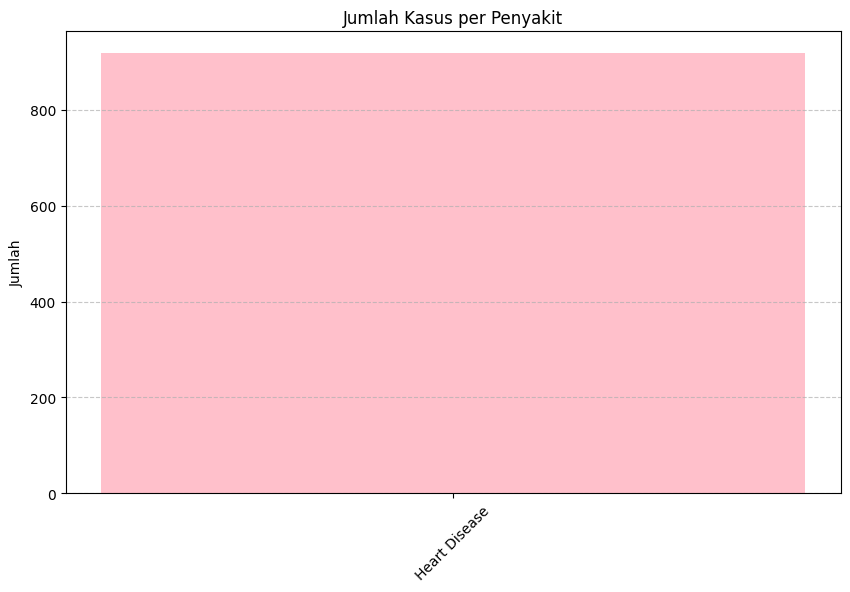

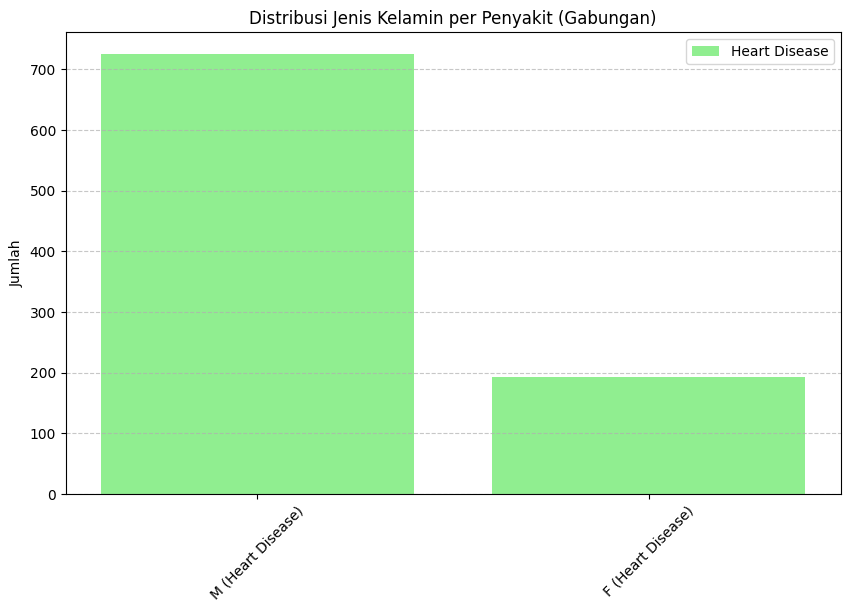

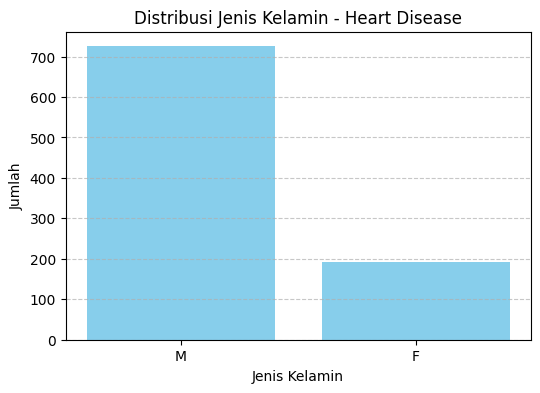

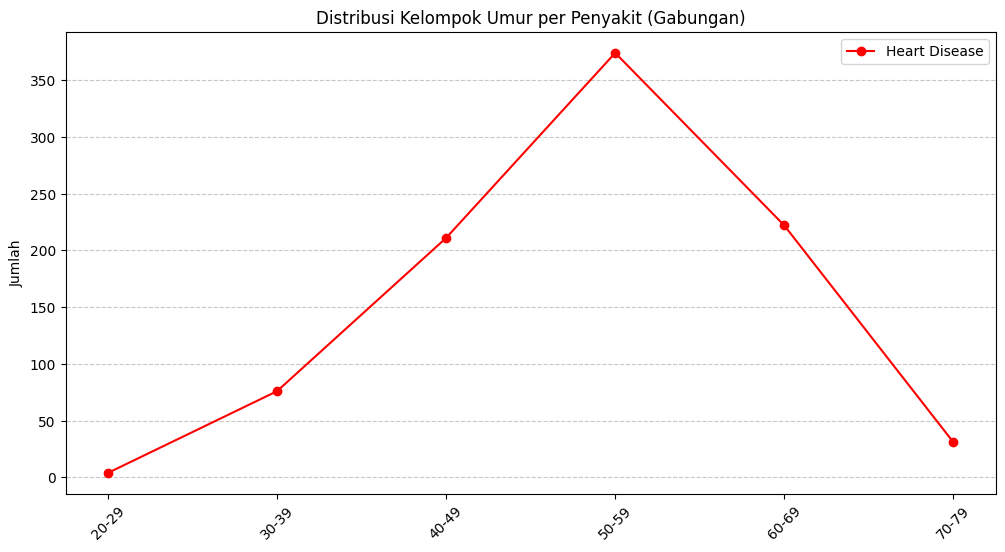

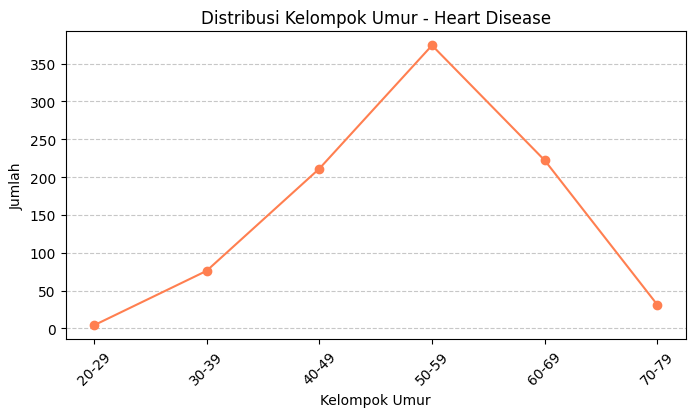

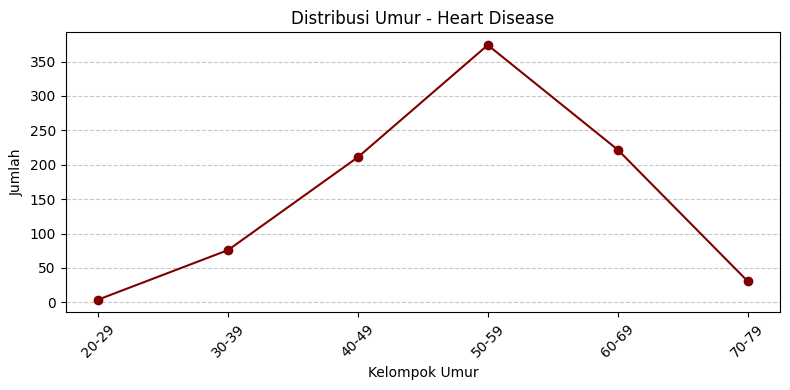

In [65]:
columns_needed = ["Age", "Sex", "JenisPenyakit"]

df_heart = df_heart.withColumn("JenisPenyakit", lit("Heart Disease"))
df_cancer = df_cancer.withColumn("JenisPenyakit", lit("Cancer"))
df_liver = df_liver.withColumn("JenisPenyakit", lit("Liver Disease"))

# Fungsi menyamakan kolom
def add_missing_cols(df, columns):
    existing_cols = df.columns
    missing_cols = [c for c in columns if c not in existing_cols]
    for col_name in missing_cols:
        if col_name == "Age":
            df = df.withColumn(col_name, lit(None).cast(IntegerType()))
        else:
            df = df.withColumn(col_name, lit(None).cast(StringType()))
    return df.select(columns)

# Transformasi DataFrame
df_heart_fixed = add_missing_cols(df_heart, columns_needed)
df_cancer_fixed = add_missing_cols(df_cancer, columns_needed)
df_liver_fixed = add_missing_cols(df_liver, columns_needed)

# Gabungkan
df_all = df_heart_fixed.unionByName(df_cancer_fixed).unionByName(df_liver_fixed)

# Ambil data mentah
raw_data = df_all.select("JenisPenyakit", "Sex", "Age").dropna().rdd.map(lambda row: (row[0], row[1], row[2])).collect()

# Fungsi Analisis
def count_disease(disease_list):
    result = {}
    for d in disease_list:
        key = d[0]
        result[key] = result.get(key, 0) + 1
    return result

def count_sex(data_list):
    result = {}
    for d in data_list:
        key = (d[0], d[1])
        result[key] = result.get(key, 0) + 1
    return result

def count_age_group(data_list):
    result = {}
    for d in data_list:
        try:
            age = int(float(d[2]))
        except:
            continue
        age_group = f"{(age//10)*10}-{(age//10)*10+9}"
        key = (d[0], age_group)
        result[key] = result.get(key, 0) + 1
    return result

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        for k, v in d.items():
            merged[k] = merged.get(k, 0) + v
    return merged

def urut_age_group(df):
    df['GroupStart'] = df['AgeGroup'].str.extract(r'(\d+)', expand=False).astype(int)
    return df.sort_values('GroupStart').drop(columns=['GroupStart'])

# Multiprocessing
chunks = np.array_split(raw_data, mp.cpu_count())

with mp.Pool() as pool:
    counts_disease = pool.map(count_disease, chunks)
    counts_sex = pool.map(count_sex, chunks)
    counts_age = pool.map(count_age_group, chunks)

final_disease = merge_dicts(counts_disease)
final_sex = merge_dicts(counts_sex)
final_age = merge_dicts(counts_age)

# Konversi ke DataFrame Pandas
df_disease = pd.DataFrame(list(final_disease.items()), columns=["JenisPenyakit", "Jumlah"])
df_sex = pd.DataFrame([(k[0], k[1], v) for k,v in final_sex.items()], columns=["JenisPenyakit", "Sex", "Jumlah"])
df_age = pd.DataFrame([(k[0], k[1], v) for k,v in final_age.items()], columns=["JenisPenyakit", "AgeGroup", "Jumlah"])

# Plot Jumlah Kasus
plt.figure(figsize=(10,6))
plt.bar(df_disease["JenisPenyakit"], df_disease["Jumlah"], color='pink')
plt.title("Jumlah Kasus per Penyakit")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Gabungan Jenis Kelamin
plt.figure(figsize=(10,6))
for penyakit in df_sex["JenisPenyakit"].unique():
    subset = df_sex[df_sex["JenisPenyakit"] == penyakit]
    plt.bar(subset["Sex"] + " (" + penyakit + ")", subset["Jumlah"], label=penyakit, color='lightgreen')
plt.title("Distribusi Jenis Kelamin per Penyakit (Gabungan)")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Jenis Kelamin per Penyakit (Terpisah)
for penyakit in df_sex["JenisPenyakit"].unique():
    subset = df_sex[df_sex["JenisPenyakit"] == penyakit]
    plt.figure(figsize=(6,4))
    plt.bar(subset["Sex"], subset["Jumlah"], color='skyblue')
    plt.title(f"Distribusi Jenis Kelamin - {penyakit}")
    plt.xlabel("Jenis Kelamin")
    plt.ylabel("Jumlah")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot Gabungan Kelompok Umur
plt.figure(figsize=(12,6))
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit].sort_values("AgeGroup")
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', label=penyakit, color='red')
plt.title("Distribusi Kelompok Umur per Penyakit (Gabungan)")
plt.xticks(rotation=45)
plt.ylabel("Jumlah")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot Umur per Penyakit (Terpisah)
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit].sort_values("AgeGroup")
    plt.figure(figsize=(8,4))
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', linestyle='-', color='coral')
    plt.title(f"Distribusi Kelompok Umur - {penyakit}")
    plt.xlabel("Kelompok Umur")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Warna yang valid ya, sayang
color_map = {
    "Heart Disease": "maroon",
    "Cancer": "orchid",
    "Liver Disease": "gold"
}

# Plot terpisah untuk setiap penyakit
for penyakit in df_age["JenisPenyakit"].unique():
    subset = df_age[df_age["JenisPenyakit"] == penyakit]
    subset = urut_age_group(subset)

    plt.figure(figsize=(8, 4))
    plt.plot(subset["AgeGroup"], subset["Jumlah"], marker='o', linestyle='-', color=color_map.get(penyakit, 'brown'))
    plt.title(f"Distribusi Umur - {penyakit}")
    plt.xlabel("Kelompok Umur")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()




### **Fungsi Program**

Program ini menggabungkan dataset penyakit yang sudah distandarisasi kolomnya, kemudian mengekstrak data mentah berupa triplet (`JenisPenyakit`, `Sex`, `Age`) untuk dianalisis. Analisis mencakup penghitungan jumlah kasus per penyakit, distribusi menurut jenis kelamin, dan distribusi menurut kelompok umur (interval 10 tahun). Penghitungan dilakukan secara paralel menggunakan multiprocessing untuk efisiensi. Hasil analisis divisualisasikan dengan beberapa grafik batang dan garis yang menggambarkan distribusi tersebut.

### **Alur Kerja Program**

1. **Standarisasi Kolom Dataset**  
   Tambahkan kolom `JenisPenyakit` pada masing-masing dataset, dan tambahkan kolom yang hilang (`Age`, `Sex`) dengan tipe data yang tepat agar semua dataset memiliki kolom yang sama dan urutan konsisten.

2. **Gabungkan Dataset**  
   Gunakan `unionByName` untuk menggabungkan dataset menjadi satu DataFrame `df_all`.

3. **Ambil Data Mentah**  
   Ambil tuple (`JenisPenyakit`, `Sex`, `Age`) dari `df_all`, buang baris dengan nilai kosong.

4. **Fungsi Hitung Statistik**  
   - `count_disease`: hitung jumlah kasus per jenis penyakit  
   - `count_sex`: hitung jumlah kasus per kombinasi penyakit dan jenis kelamin  
   - `count_age_group`: hitung jumlah kasus per kombinasi penyakit dan kelompok umur (rentang 10 tahun)

5. **Fungsi Penggabungan Hasil**  
   Gabungkan hasil hitungan dari proses multiprocessing yang berbeda menjadi satu dictionary hasil akhir.

6. **Pembagian Data untuk Paralelisme**  
   Bagi data mentah menjadi sejumlah chunk sesuai jumlah core CPU.

7. **Jalankan Paralelisme**  
   Gunakan multiprocessing pool untuk menjalankan fungsi hitung secara paralel.

8. **Konversi ke DataFrame Pandas**  
   Hasil akhir dikonversi menjadi DataFrame untuk kemudahan analisis dan visualisasi.

9. **Visualisasi Data**  
   Buat beberapa plot:  
   - Jumlah kasus per penyakit (bar chart)  
   - Distribusi jenis kelamin gabungan dan per penyakit (bar chart)  
   - Distribusi kelompok umur gabungan dan per penyakit (line chart)  
   - Plot terpisah dengan warna berbeda sesuai jenis penyakit


### **MONITORING CPU**

In [73]:
import psutil
print(f"Jumlah CPU tersedia: {psutil.cpu_count(logical=True)}")
print(f"Penggunaan CPU saat ini: {psutil.cpu_percent()}%")


Jumlah CPU tersedia: 2
Penggunaan CPU saat ini: 17.5%




### **Fungsi Program**

Program ini bertujuan untuk menampilkan informasi mengenai jumlah core CPU yang tersedia di sistem serta persentase penggunaan CPU secara keseluruhan pada saat dijalankan. Informasi ini penting untuk memantau kapasitas dan beban kerja CPU secara real-time.


### **Alur Kerja Program**

1. **Import Library**  
   Mengimpor modul `psutil` yang digunakan untuk mengambil informasi sistem.

2. **Ambil Jumlah Core CPU**  
   Memanggil fungsi `psutil.cpu_count(logical=True)` untuk mendapatkan jumlah core CPU logis (termasuk hyper-threading).

3. **Ambil Persentase Penggunaan CPU Saat Ini**  
   Memanggil fungsi `psutil.cpu_percent()` untuk mendapatkan persentase pemakaian CPU keseluruhan selama interval pendek default.

4. **Cetak Hasil**  
   Menampilkan jumlah core CPU dan persentase penggunaan CPU ke layar.